<a href="https://colab.research.google.com/github/antoniomuso/speech2face/blob/master/NewDecoder_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
vox1_path = "/content/drive/My Drive/Speech2Face/vox1_dataset/"
img = vox1_path+"unzippedFaces"
! pip3 install face_recognition
! pip3 install tensorflow-gpu==1.15

     |████████████████████████████████| 100.2MB 104kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=ad8c0a112065dfc8c34ac8427ffb9f5450363a93ad9bf72083d0c46628a95efb
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models
     |████████████████████████████████| 411.5MB 40kB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 3.8MB 38.6MB/s 
     |████████████████████████████████| 512kB 35.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=5935c91fb7a31a0ccd350324645d82dd7619a8913d69f252fa7e6ff758084d9e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.

In [3]:
# !wget http://www.robots.ox.ac.uk/~vgg/research/CMBiometrics/data/zippedFaces.tar.gz 
# !tar zxvf zippedFaces.tar.gz -C "/content/drive/My Drive/Speech2Face/vox1_dataset/"

In [4]:
# !curl --user voxceleb1912:0s42xuw6 -o "/content/drive/My Drive/Speech2Face/ff/vox.zip" http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip

In [15]:
import glob

import numpy as np
import sys

from PIL import Image
from torch.utils.data import Dataset
import  torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from face_recognition import face_landmarks, face_locations, face_encodings
from random import randint



def load_metadata(data_file_path):
    data_list = []
    with open(data_file_path, "r") as f:
        for line in f:
            data_list.append(line.rstrip("\n").split(","))
    return data_list


class _Normalize_Tensor(object):
    def __init__(self, color_mean, color_std):
        self.color_mean = color_mean
        self.color_std = color_std

    def __call__(self, img):
        # Convert image to Tensor
        img = transforms.functional.to_tensor(img)

        # Normalize image by the parameter of pre-trained face-encoder
        img = transforms.functional.normalize(
            img, self.color_mean, self.color_std)

        return img

class EmbedImagePairs(Dataset):
    def __init__(self, data_list_path, face_encoder, mean, std, device, size=64):
        super().__init__()
        self.images = ImageFolder(data_list_path)

        self.face_encoder = face_encoder

        self.color_mean = mean
        self.color_std = std
        
        self.device = device
        self.size = size

        # Transform input for face-encoder
        self.transform_fe = transforms.Compose([
            transforms.Resize((224, 224)),
            _Normalize_Tensor(self.color_mean, self.color_std)
        ])

        self.transform_fd = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
            
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load face-image
        image = self.images[idx][0]

        # convert face-images into 4096-dim vectors
        self.face_encoder.eval()

        
        # Localize Face
        np_image = np.array(image)
        #face_loc = face_locations(np_image)
        
        try:
          #x,y1,x1,y = face_loc[0]
          #image = image.crop((x,y,x1,y1))

          resultant = []
          #np_image = np_image[x:x1,y:y1]
          landmark = face_landmarks(np_image)
          for i in list(landmark[0].keys()):
            resultant += landmark[0][i]
          landmark = np.ravel(np.array(resultant))

        except IndexError:
          return self[randint(0, len(self))]

        face_vectors = self.face_encoder(
            self.transform_fe(image).unsqueeze_(0).to(self.device))

        image_ = self.transform_fd(image)

        return face_vectors, torch.tensor(landmark).float(), image_

In [6]:
import torch
import torch.nn as nn


class Vgg_face_dag(nn.Module):

    def __init__(self):
        super(Vgg_face_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)

    def forward(self, x0, is_fc8=False):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        if is_fc8:
            x38 = self.fc8(x37)
        else:
            x38 = x37
        return x38


def vgg_face_dag(weights_path=None, **kwargs):
    """
    load imported model instance
    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_face_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [7]:
import torch
import torch.nn.functional as F
from torch import nn

class DECODER(nn.Module):
    def __init__(self, phase):
        super(DECODER, self).__init__()
        self.phase = phase
        self.fc3 = nn.Linear(4096, 1000)
        self.ReLU = nn.ReLU()
        #self.fc_bn3 = nn.BatchNorm1d(1000)


        self.fc4 = nn.Linear(1000, 14 * 14 * 256)
        self.fc_bn4 = nn.BatchNorm1d(14 * 14 * 256)
        def TransConv( i, kernal = 5, stride = 2, inp = None):
            if not inp:
                inp = max(256//2**(i-1), 32)

            layer =  nn.Sequential(
                nn.ConvTranspose2d(inp, max(256//2**i, 32), 
                                kernal, stride=stride, padding=2, output_padding=1, 
                                dilation=1, padding_mode='zeros'),
                nn.ReLU(),
                nn.BatchNorm2d(max(256//2**i, 32)))
            return layer
        self.T1_ = TransConv(1, inp = 256)
        self.T2_ = TransConv(2)
        self.T3_ = TransConv(3)
        self.T4_ = TransConv(4)
    
        self.ConvLast = nn.Sequential(
            nn.Conv2d(32, 3, (1,1), stride=1),
            nn.BatchNorm2d(3),
            nn.ReLU())


        self.layerLandmark1 = nn.Linear(1000, 800)
        self.layerLandmark2 = nn.Linear(800, 600)
        self.layerLandmark3 = nn.Linear(600, 400)
        self.layerLandmark4 = nn.Linear(400, 200)
        self.layerLandmark5 = nn.Linear(200, 144)

    def forward(self, x):
        L1 = self.fc3(x)
        L1 = self.ReLU(L1)


        L2 = self.layerLandmark1(L1)
        L2 = self.ReLU(L2)

        L3 = self.layerLandmark2(L2)
        L3 = self.ReLU(L3)

        L4 = self.layerLandmark3(L3)
        L4 = self.ReLU(L4)

        L5 = self.layerLandmark4(L4)
        L5 = self.ReLU(L5)

        L6 = self.layerLandmark5(L5)
        outL = self.ReLU(L6)


        # B1 = self.fc_bn3(L1) 
        T0 = self.fc4(L1) 
        T0 = self.ReLU(T0)
        # T0 = self.fc_bn4(T0)
        T0 = T0.view(-1,256,14,14)



        T1 = self.T1_(T0)
        T2 = self.T2_(T1)
        T3 = self.T3_(T2)
        T4 = self.T4_(T3)

        outT = self.ConvLast(T4)
        if self.phase == "train":
            return outL,  outT 

In [8]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x
    
class Resize(object):
    def __init__(self, input_size):
        self.input_size = input_size
        
    def __call__(self, img):
        img = img.resize((self.input_size, self.input_size),
                                Image.BICUBIC)
        return img
    
class Normalize_Tensor(object):
    def __init__(self, color_mean, color_std):
        self.color_mean = color_mean
        self.color_std = color_std

    def __call__(self, img):

        # PIL画像をTensorに。大きさは最大1に規格化される
        img = transforms.functional.to_tensor(img)

        # 色情報の標準化
        img = transforms.functional.normalize(
            img, self.color_mean, self.color_std)

        return img

class ImageTransform():
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train' : Compose([
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std)
            ]),
            'val' : Compose([
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std)
            ])
        }
    
    def __call_(self, phase, img):
        return self.data_transform[phase](img)

In [9]:
############### THIS CELL IS COPIED FROM DEEP SPEECH MOZILLA #########################


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import tensorflow.compat.v1 as tfv1
from tensorflow.compat import dimension_value
from tensorflow.contrib.image import dense_image_warp
from tensorflow.contrib.image import interpolate_spline

from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops

def _to_float32(value):
    return tf.cast(value, tf.float32)

def _to_int32(value):
    return tf.cast(value, tf.int32)

def _get_grid_locations(image_height, image_width):
    """Wrapper for np.meshgrid."""
    tfv1.assert_type(image_height, tf.int32)
    tfv1.assert_type(image_width, tf.int32)

    y_range = tf.range(image_height)
    x_range = tf.range(image_width)
    y_grid, x_grid = tf.meshgrid(y_range, x_range, indexing='ij')
    return tf.stack((y_grid, x_grid), -1)


def _expand_to_minibatch(tensor, batch_size):
    """Tile arbitrarily-sized np_array to include new batch dimension."""
    ndim = tf.size(tf.shape(tensor))
    ones = tf.ones((ndim,), tf.int32)

    tiles = tf.concat(([batch_size], ones), 0)
    return tf.tile(tf.expand_dims(tensor, 0), tiles)


def _get_boundary_locations(image_height, image_width, num_points_per_edge):
    """Compute evenly-spaced indices along edge of image."""
    image_height_end = _to_float32(tf.math.subtract(image_height, 1))
    image_width_end = _to_float32(tf.math.subtract(image_width, 1))
    y_range = tf.linspace(0.0, image_height_end, num_points_per_edge + 2)
    x_range = tf.linspace(0.0, image_height_end, num_points_per_edge + 2)
    ys, xs = tf.meshgrid(y_range, x_range, indexing='ij')
    is_boundary = tf.logical_or(
        tf.logical_or(tf.equal(xs, 0.0), tf.equal(xs, image_width_end)),
        tf.logical_or(tf.equal(ys, 0.0), tf.equal(ys, image_height_end)))
    return tf.stack([tf.boolean_mask(ys, is_boundary), tf.boolean_mask(xs, is_boundary)], axis=-1)


def _add_zero_flow_controls_at_boundary(control_point_locations,
                                        control_point_flows, image_height,
                                        image_width, boundary_points_per_edge):
    """Add control points for zero-flow boundary conditions.
     Augment the set of control points with extra points on the
     boundary of the image that have zero flow.
    Args:
      control_point_locations: input control points
      control_point_flows: their flows
      image_height: image height
      image_width: image width
      boundary_points_per_edge: number of points to add in the middle of each
                             edge (not including the corners).
                             The total number of points added is
                             4 + 4*(boundary_points_per_edge).
    Returns:
      merged_control_point_locations: augmented set of control point locations
      merged_control_point_flows: augmented set of control point flows
    """

    batch_size = dimension_value(tf.shape(control_point_locations)[0])

    boundary_point_locations = _get_boundary_locations(image_height, image_width,
                                                       boundary_points_per_edge)
    boundary_point_shape = tf.shape(boundary_point_locations)
    boundary_point_flows = tf.zeros([boundary_point_shape[0], 2])

    minbatch_locations = _expand_to_minibatch(boundary_point_locations, batch_size)
    type_to_use = control_point_locations.dtype
    boundary_point_locations = tf.cast(minbatch_locations, type_to_use)

    minbatch_flows = _expand_to_minibatch(boundary_point_flows, batch_size)

    boundary_point_flows = tf.cast(minbatch_flows, type_to_use)

    merged_control_point_locations = tf.concat(
        [control_point_locations, boundary_point_locations], 1)

    merged_control_point_flows = tf.concat(
        [control_point_flows, boundary_point_flows], 1)

    return merged_control_point_locations, merged_control_point_flows


def sparse_image_warp(image,
                      source_control_point_locations,
                      dest_control_point_locations,
                      interpolation_order=2,
                      regularization_weight=0.0,
                      num_boundary_points=0,
                      name='sparse_image_warp'):
    """Image warping using correspondences between sparse control points.
    Apply a non-linear warp to the image, where the warp is specified by
    the source and destination locations of a (potentially small) number of
    control points. First, we use a polyharmonic spline
    (`tf.contrib.image.interpolate_spline`) to interpolate the displacements
    between the corresponding control points to a dense flow field.
    Then, we warp the image using this dense flow field
    (`tf.contrib.image.dense_image_warp`).
    Let t index our control points. For regularization_weight=0, we have:
    warped_image[b, dest_control_point_locations[b, t, 0],
                    dest_control_point_locations[b, t, 1], :] =
    image[b, source_control_point_locations[b, t, 0],
             source_control_point_locations[b, t, 1], :].
    For regularization_weight > 0, this condition is met approximately, since
    regularized interpolation trades off smoothness of the interpolant vs.
    reconstruction of the interpolant at the control points.
    See `tf.contrib.image.interpolate_spline` for further documentation of the
    interpolation_order and regularization_weight arguments.
    Args:
      image: `[batch, height, width, channels]` float `Tensor`
      source_control_point_locations: `[batch, num_control_points, 2]` float
        `Tensor`
      dest_control_point_locations: `[batch, num_control_points, 2]` float
        `Tensor`
      interpolation_order: polynomial order used by the spline interpolation
      regularization_weight: weight on smoothness regularizer in interpolation
      num_boundary_points: How many zero-flow boundary points to include at
        each image edge.Usage:
          num_boundary_points=0: don't add zero-flow points
          num_boundary_points=1: 4 corners of the image
          num_boundary_points=2: 4 corners and one in the middle of each edge
            (8 points total)
          num_boundary_points=n: 4 corners and n-1 along each edge
      name: A name for the operation (optional).
      Note that image and offsets can be of type tf.half, tf.float32, or
      tf.float64, and do not necessarily have to be the same type.
    Returns:
      warped_image: `[batch, height, width, channels]` float `Tensor` with same
        type as input image.
      flow_field: `[batch, height, width, 2]` float `Tensor` containing the dense
        flow field produced by the interpolation.
    """

    image = ops.convert_to_tensor(image)
    source_control_point_locations = ops.convert_to_tensor(
        source_control_point_locations)
    dest_control_point_locations = ops.convert_to_tensor(
        dest_control_point_locations)

    control_point_flows = (
        dest_control_point_locations - source_control_point_locations)

    clamp_boundaries = num_boundary_points > 0
    boundary_points_per_edge = num_boundary_points - 1

    with ops.name_scope(name):
        image_shape = tf.shape(image)
        batch_size, image_height, image_width = image_shape[0], image_shape[1], image_shape[2]

        # This generates the dense locations where the interpolant
        # will be evaluated.
        grid_locations = _get_grid_locations(image_height, image_width)

        flattened_grid_locations = tf.reshape(grid_locations,
                                              [tf.multiply(image_height, image_width), 2])

        # flattened_grid_locations = constant_op.constant(
        #     _expand_to_minibatch(flattened_grid_locations, batch_size), image.dtype)
        flattened_grid_locations = _expand_to_minibatch(flattened_grid_locations, batch_size)
        flattened_grid_locations = tf.cast(flattened_grid_locations, dtype=image.dtype)

        if clamp_boundaries:
            (dest_control_point_locations,
             control_point_flows) = _add_zero_flow_controls_at_boundary(
                 dest_control_point_locations, control_point_flows, image_height,
                 image_width, boundary_points_per_edge)

        flattened_flows = interpolate_spline(
            dest_control_point_locations, control_point_flows,
            flattened_grid_locations, interpolation_order, regularization_weight)

        dense_flows = array_ops.reshape(flattened_flows,
                                        [batch_size, image_height, image_width, 2])

        warped_image = dense_image_warp(image, dense_flows)

        return warped_image, dense_flows

In [19]:
def image_warping(src_img, src_landmarks, dest_landmarks):
    # expanded_src_landmarks = np.expand_dims(np.float32(src_landmarks), axis=0)
    # expanded_dest_landmarks = np.expand_dims(np.float32(dest_landmarks), axis=0)
    # expanded_src_img = np.expand_dims(np.float32(src_img) / 255, axis=0)

    warped_img, dense_flows = sparse_image_warp(src_img,
                          src_landmarks,
                          dest_landmarks,
                          interpolation_order=1,
                          regularization_weight=0.1,
                          num_boundary_points=2,
                          name='sparse_image_warp')

    with tf.Session() as sess:
        out_img = sess.run(warped_img)
        warp_img = np.uint8(out_img[:, :, :, :] * 255)
    
    return warp_img
    
def face_landmark(img):
    X = np.zeros((img.shape[0], 72 ,2))
    flag = []
    for i in range(img.shape[0]):

        landmark = face_landmarks(img[i].reshape(224,224,3))
        resultant = []
        try:
            for j in list(landmark[0].keys()):
                resultant += landmark[0][j] 
        except IndexError:
            flag.append(i)
            continue
        X[i] = np.array(resultant)
    return  X, flag

In [11]:
from torch import nn, optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Set Model
model = DECODER('train').to(device)
print('Created Generator')
# Set loss and optimizer
criterion = nn.MSELoss()
criterion2 = nn.L1Loss()
alpha = 0.0002
beta  = 1.0
optimizer = optim.Adam(model.parameters())

Created Generator


Image Pairing








  0%|          | 0/151 [00:00<?, ?it/s]

Creating dataloader
Start Training


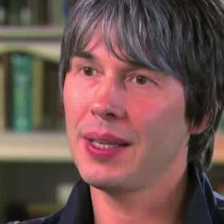

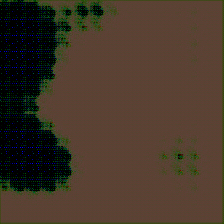

loss: 1.4027082920074463 Steps: 2/158093
torch.Size([2, 3, 224, 224])


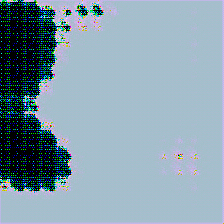

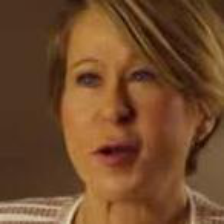

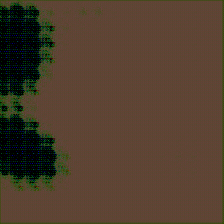

loss: 1.1372357606887817 Steps: 4/158093
torch.Size([2, 3, 224, 224])


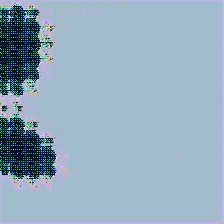

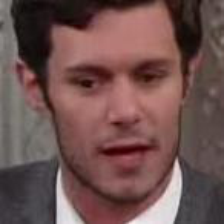

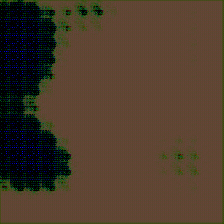

loss: 0.9879339933395386 Steps: 6/158093
torch.Size([2, 3, 224, 224])


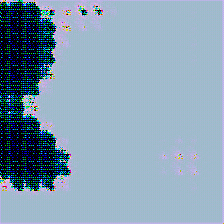

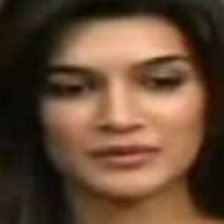

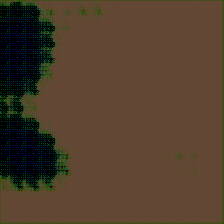

loss: 0.9755051136016846 Steps: 8/158093
torch.Size([2, 3, 224, 224])


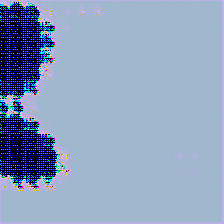

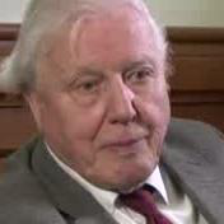

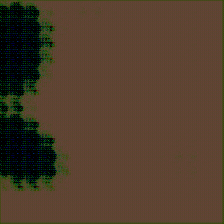

loss: 1.0362273454666138 Steps: 10/158093
torch.Size([2, 3, 224, 224])


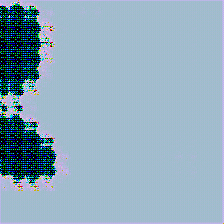

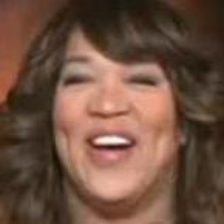

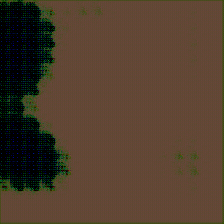

loss: 0.994322657585144 Steps: 12/158093
torch.Size([2, 3, 224, 224])


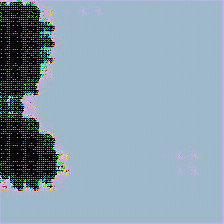

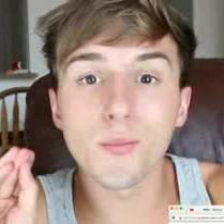

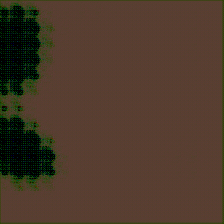

loss: 1.1359002930777413 Steps: 14/158093
torch.Size([2, 3, 224, 224])


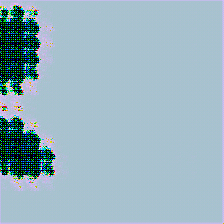

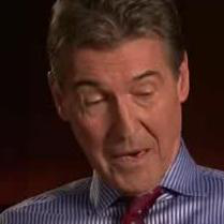

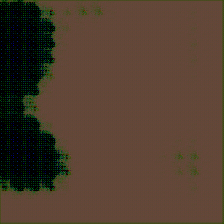

loss: 1.2395585179328918 Steps: 16/158093
torch.Size([2, 3, 224, 224])


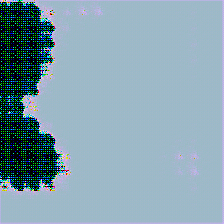

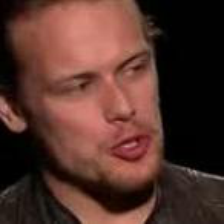

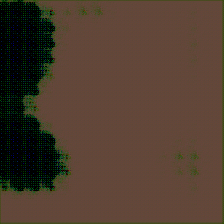

loss: 1.2861627870135837 Steps: 18/158093
torch.Size([2, 3, 224, 224])


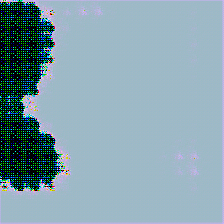

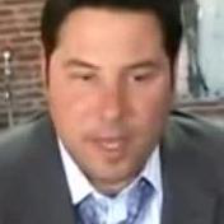

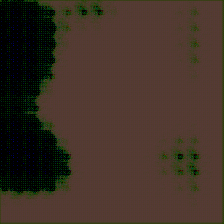

loss: 1.3397453665733337 Steps: 20/158093
torch.Size([2, 3, 224, 224])


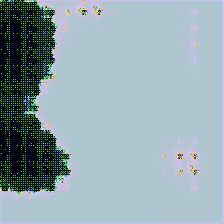

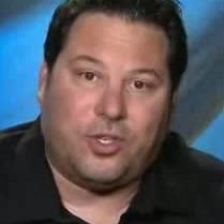

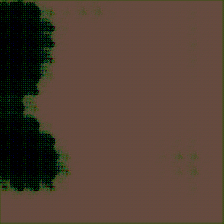

loss: 1.3961441950364546 Steps: 22/158093
torch.Size([2, 3, 224, 224])


KeyboardInterrupt: ignored

In [31]:
import argparse
import os
from os.path import join

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import cv2


#from dataloader import EmbedImagePairs
#from face_encoder_model import vgg_face_dag
#from face_decoder_model import Generator


global_epoch = 0

def _save_model(epoch, model, optimizer, steps, fname):
    torch.save({
        'steps': steps,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, join(output_dir_name, 'epoch_{}_steps_{}.pth'.format(epoch, steps)))


def train_epoch(model, trn_dataloader, criterion, optimizer, device):
    model.train()

    running_loss = 0
    dataset_len = len(trn_dataloader.dataset)

    count = 0
    numOfElements = 0
    saving_steps = 100

    for x,landmark, y in trn_dataloader:
        count += 1
        x = x.squeeze().to(device)  

        y_img = cv2.cvtColor(np.einsum('abc->bca',y[0].numpy()*255),cv2.COLOR_BGR2RGB)
        cv2_imshow(y_img)

        y = y.to(device)
        landmark = landmark.to(device)

        optimizer.zero_grad()

        outLandmark, outputs  = model(x)

        loss2 = criterion2(outputs, y)
        loss1 = criterion(outLandmark, landmark)

        loss = (alpha*loss1 + beta*loss2 )
        
        loss.backward()
        
        optimizer.step()
        
        o_img = cv2.cvtColor(np.einsum('abc->bca',outputs[0].cpu().detach().numpy()*255),cv2.COLOR_BGR2RGB)
        cv2_imshow(o_img)
        running_loss += loss.item() * x.size(0)
        numOfElements += x.shape[0]
        print("loss:", running_loss / count, "Steps:", str(numOfElements) + "/" + str(dataset_len) )

        if (numOfElements % (x.shape[0] * saving_steps)) == 0:
          _save_model(epoch, model, optimizer, numOfElements, output_dir_name)

        
        outLandmark = outLandmark.cpu().detach().numpy()
        outLandmark = np.dstack((outLandmark[:,0::2],outLandmark[:,1::2]))
        print(outputs.shape)
        #print("land np img np ", outL_.shape, img_.shape)
        img1 = np.einsum('dabc->dbca',outputs.cpu().detach().numpy()*255)
        img1 = (img1).astype(np.uint8)
        #print("img_t ",img_t.shape, img_t[0])
        src, flag = face_landmark(img1)
        if flag:
            for r in flag:
                src[r] = outLandmark[r]
        result = image_warping(img1.astype(np.float32), src.astype(np.float32), outLandmark.astype(np.float32))

        w_img = cv2.cvtColor(result[0], cv2.COLOR_BGR2RGB)
        cv2_imshow(w_img)
    
    trn_loss = running_loss/len(trn_dataloader.dataset)
    
    return trn_loss


def train(model, dataloaders, criterion, optimizer, device, output_dir_name, num_epochs=100):
    trn_losses = []

    # make dir where trained model saved
    os.makedirs(output_dir_name, exist_ok=True)

    # start at zero, end at num_epochs (including)
    print("Start Training")
    for epoch in tqdm(range(global_epoch, num_epochs+1)):
        # Training phase
        trn_loss = train_epoch(model, dataloaders, criterion, optimizer, device)
        trn_losses += [trn_loss]
        print("Epoch: {}  || Loss: {}".format(epoch, trn_loss))
    
        _save_model(epoch, model, optimizer, output_dir_name)


base_dir='/content/drive/My Drive/Speech2Face/'
input="vox1_dataset/unzippedFaces"
batch_size=2
num_epochs=150
checkpoint_path=None




# Load face-encoder model
face_encoder_path = join(base_dir, "Pretrained", "vgg_face_dag.pth")
face_encoder_model = vgg_face_dag(face_encoder_path).to(device)
color_mean, color_std = face_encoder_model.meta["mean"], face_encoder_model.meta["std"]
color_mean = [tmp / 255.0 for tmp in color_mean]
color_std = [tmp / 255.0 for tmp in color_std]

# Set DataLoader
input_path = join(base_dir, input)
print('Image Pairing')
dataset = EmbedImagePairs(input_path, face_encoder_model,
                          color_mean, color_std, device)
print('Creating dataloader')
trn_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
output_dir_name = join(base_dir, "models", "face_decoder_warping")
if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    global_epoch = checkpoint["epoch"]
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# Train
train(model, trn_dataloader, criterion, optimizer, device, output_dir_name, num_epochs=num_epochs)
print("Finish training")

In [ ]:
_save_model(1, model, optimizer, 'no_preprocessing')